In [1]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tqdm import tqdm  # Thanh tiến trình
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing import image
from sklearn.neighbors import NearestNeighbors
import random

# --- CẤU HÌNH ĐƯỜNG DẪN ---
# Đường dẫn dataset trên Kaggle của bạn
IMAGE_FOLDER = "/kaggle/input/img-for-pbl/product_images_downloaded"
IMG_WIDTH, IMG_HEIGHT = 224, 224

# Kiểm tra xem thư mục có tồn tại không
if not os.path.exists(IMAGE_FOLDER):
    print(f"Lỗi: Không tìm thấy thư mục {IMAGE_FOLDER}")
else:
    print(f" Đã tìm thấy thư mục: {IMAGE_FOLDER}")

2025-11-26 04:43:18.140519: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764132198.337853      20 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764132198.392217      20 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

 Đã tìm thấy thư mục: /kaggle/input/img-for-pbl/product_images_downloaded


In [3]:
# Load model ResNet50 (bỏ lớp phân loại cuối cùng, lấy pooling='avg')
print(" Đang tải model ResNet50...")
base_model = ResNet50(weights='imagenet', include_top=False, pooling='avg')
print(" Model đã sẵn sàng!")

 Đang tải model ResNet50...


I0000 00:00:1764132214.313082      20 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
 Model đã sẵn sàng!


In [4]:
def extract_features(img_path, model):
    """Hàm chuyển đổi 1 file ảnh thành vector đặc trưng (2048 chiều)"""
    try:
        # Load ảnh và resize về kích thước chuẩn của ResNet (224x224)
        img = image.load_img(img_path, target_size=(IMG_WIDTH, IMG_HEIGHT))
        
        # Chuyển thành mảng numpy
        img_array = image.img_to_array(img)
        
        # Thêm chiều batch (1, 224, 224, 3)
        expanded_img_array = np.expand_dims(img_array, axis=0)
        
        # Tiền xử lý (trừ trung bình màu theo chuẩn ImageNet)
        preprocessed_img = preprocess_input(expanded_img_array)
        
        # Dự đoán để lấy features
        features = model.predict(preprocessed_img, verbose=0)
        
        # Làm phẳng vector (flatten)
        return features.flatten()
    except Exception as e:
        # Bỏ qua nếu file lỗi
        return None

In [5]:
all_files = []
valid_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.webp')

if os.path.exists(IMAGE_FOLDER):
    for root, dirs, files in os.walk(IMAGE_FOLDER):
        for file in files:
            if file.lower().endswith(valid_extensions):
                all_files.append(os.path.join(root, file))
    print(f"{len(all_files)} ảnh.")
else:
    all_files = []

9335 ảnh.


In [6]:

BATCH_SIZE = 64 
filenames = []
feature_list = []

print(f" Bắt đầu trích xuất đặc trưng theo Batch (Size={BATCH_SIZE})...")

def load_and_preprocess_batch(batch_paths):
    batch_imgs = []
    valid_paths = []
    
    for img_path in batch_paths:
        try:
            # Load ảnh và resize
            img = image.load_img(img_path, target_size=(IMG_WIDTH, IMG_HEIGHT))
            img_array = image.img_to_array(img)
            
            # Khắc phục lỗi Transparency warning của PIL
            if img_array.shape[-1] == 4: # Nếu là ảnh 4 kênh (PNG trong suốt)
                img_array = img_array[:,:,:3] # Bỏ kênh Alpha
            
            batch_imgs.append(img_array)
            valid_paths.append(img_path)
        except Exception as e:
            # Bỏ qua ảnh lỗi
            continue
            
    if not batch_imgs:
        return None, []
        
    # Chuyển list thành numpy array (Batch_Size, 224, 224, 3)
    batch_imgs = np.array(batch_imgs)
    # Tiền xử lý theo chuẩn ResNet
    batch_imgs = preprocess_input(batch_imgs)
    
    return batch_imgs, valid_paths

# --- VÒNG LẶP CHÍNH ---
# Duyệt qua danh sách file theo từng bước nhảy (step) = BATCH_SIZE
for i in tqdm(range(0, len(all_files), BATCH_SIZE), desc="Processing Batches"):
    # Lấy danh sách đường dẫn cho batch hiện tại
    batch_paths = all_files[i : i + BATCH_SIZE]
    
    # Load và xử lý ảnh CPU
    batch_input, valid_paths = load_and_preprocess_batch(batch_paths)
    
    if batch_input is not None:
        batch_features = base_model.predict(batch_input, verbose=0)
        feature_list.extend(batch_features)
        filenames.extend(valid_paths)

# Chuyển kết quả cuối cùng sang numpy
feature_list = np.array(feature_list)

print(f"\n Hoàn tất! Đã xử lý {len(feature_list)} ảnh.")
print(f"Shape dữ liệu: {feature_list.shape}")

 Bắt đầu trích xuất đặc trưng theo Batch (Size=64)...


Processing Batches:   0%|          | 0/146 [00:00<?, ?it/s]WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
I0000 00:00:1764132242.503621      58 service.cc:148] XLA service 0x7fbb40002b00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1764132242.504425      58 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1764132243.108867      58 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1764132246.164571      58 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
Processing Batches:   2%|▏         | 3/146 [00:12<08:24,  3.53s/it]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Processing Batches: 100%|██████████| 146/146 [05:35<00:00,  2.30s/it]


 Hoàn tất! Đã xử lý 9335 ảnh.
Shape dữ liệu: (9335, 2048)


In [7]:
# Lưu model
import pickle
print(" Đang lưu dữ liệu...")
np.save('/kaggle/working/features.npy', feature_list)
with open('/kaggle/working/filenames.pkl', 'wb') as f:
    pickle.dump(filenames, f)
print(" Đã lưu xong: features.npy và filenames.pkl")

 Đang lưu dữ liệu...
 Đã lưu xong: features.npy và filenames.pkl


In [8]:
PATH_FEATURES = '/kaggle/working/features.npy'
PATH_FILENAMES = '/kaggle/working/filenames.pkl'

try:
    feature_list = np.load(PATH_FEATURES)
    with open(PATH_FILENAMES, 'rb') as f:
        filenames = pickle.load(f)
    print(f"Đã load xong kho dữ liệu: {len(feature_list)} ảnh.")
except FileNotFoundError:
    print("Lỗi: Không tìm thấy file .npy hoặc .pkl. Hãy chạy bước Indexing trước!")
    exit()

Đã load xong kho dữ liệu: 9335 ảnh.


In [9]:
# Khởi tạo thuật toán KNN với khoảng cách cosine
neighbors = NearestNeighbors(n_neighbors=6, algorithm='brute', metric='cosine')
neighbors.fit(feature_list)

NearestNeighbors(algorithm='brute', metric='cosine', n_neighbors=6)

In [10]:
def search_similar_images(query_img_path, show_result=True):
    # 1. Trích xuất đặc trưng của ảnh đầu vào
    query_feature = extract_features(query_img_path, base_model)
    
    if query_feature is None:
        print(" Không thể đọc ảnh đầu vào.")
        return

    # 2. Tìm 6 ảnh gần nhất (bao gồm cả chính nó nếu có trong dataset)
    distances, indices = neighbors.kneighbors([query_feature])
    
    # 3. Hiển thị kết quả
    if show_result:
        plt.figure(figsize=(15, 6))
        
        # --- HIỂN THỊ ẢNH GỐC (QUERY) ---
        ax = plt.subplot(1, 6, 1)
        try:
            plt.imshow(mpimg.imread(query_img_path))
        except:
            pass # Lỗi đọc ảnh thì bỏ qua
        plt.title("QUERY IMAGE\n(Ảnh gốc)", color='red', fontweight='bold')
        plt.axis('off')
        
        # show 5 ảnh tương tự
        
        found_count = 0
        
        # Lấy index từ danh sách kết quả
        for i, index in enumerate(indices[0]):
            if found_count >= 5: break # Chỉ lấy 5 ảnh
            
            result_path = filenames[index]
            dist = distances[0][i]
            
            # Nếu khoảng cách = 0 (là chính ảnh đó), bỏ qua để tìm ảnh khác
            if dist < 1e-5 and result_path == query_img_path:
                continue
                
            found_count += 1
            
            ax = plt.subplot(1, 6, found_count + 1)
            try:
                plt.imshow(mpimg.imread(result_path))
                # Lấy tên file ngắn gọn
                name = os.path.basename(result_path[10:])
                plt.title(f"{name}\nDist: {dist:.4f}", fontsize=10)
            except:
                plt.title("Error")
            plt.axis('off')
            
        plt.tight_layout()
        plt.show()

Ảnh tương tự cho: /kaggle/input/img-for-pbl/product_images_downloaded/PRD-96394C6C-1BCC-b228c695.jpg


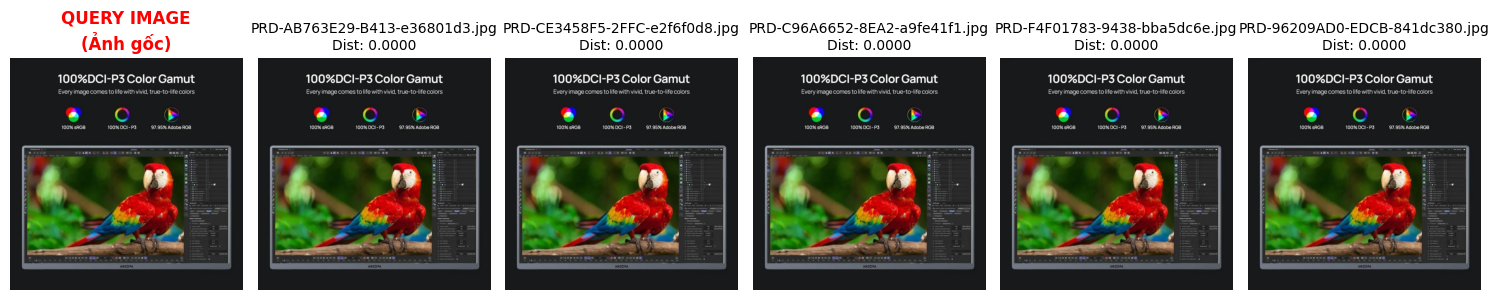

Ảnh tương tự cho: /kaggle/input/img-for-pbl/product_images_downloaded/PRD-96394C6C-54E0-171b42f6.jpg


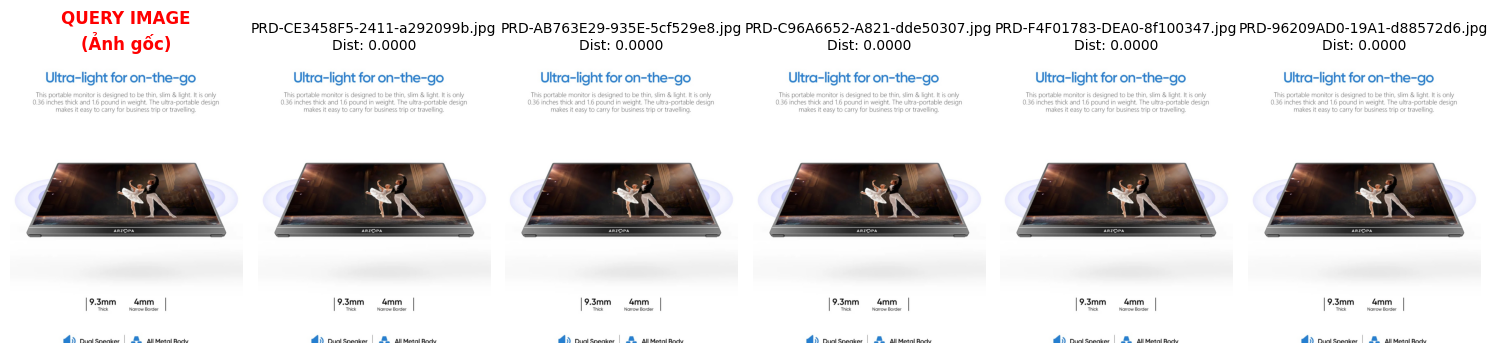

In [11]:
if len(filenames) > 0:
    # Lấy ngẫu nhiên 1 ảnh để test
    test_image_path = random.choice(filenames)
    
    print(f"Ảnh tương tự cho: {test_image_path}")
    search_similar_images(test_image_path)
    
    test_image_path = random.choice(filenames)
    
    print(f"Ảnh tương tự cho: {test_image_path}")
    search_similar_images(test_image_path)
else:
    print("Lỗi rồi bro")

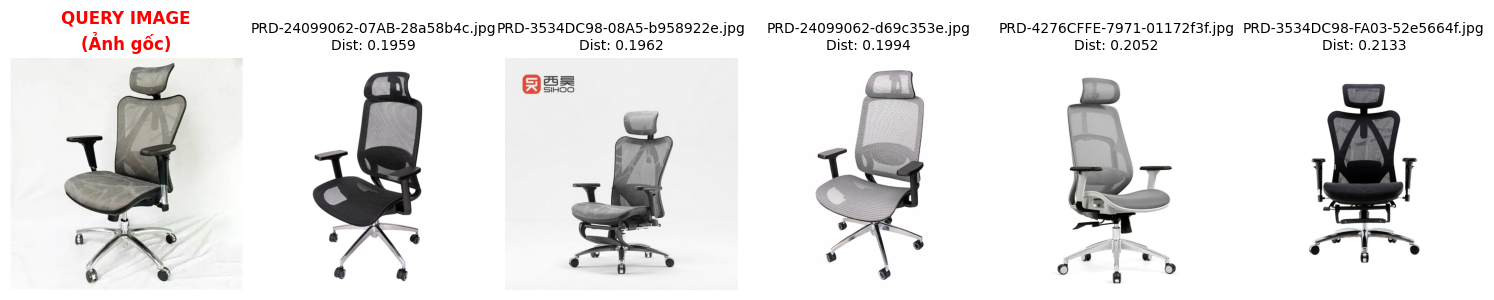

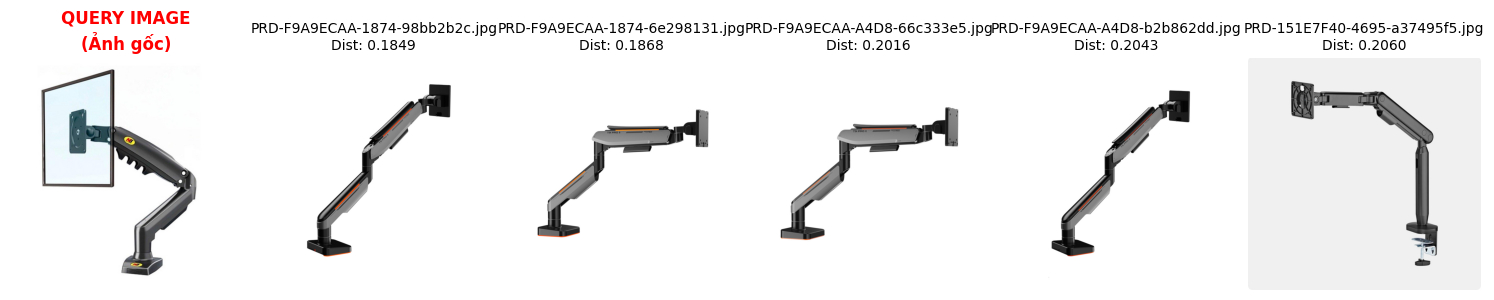

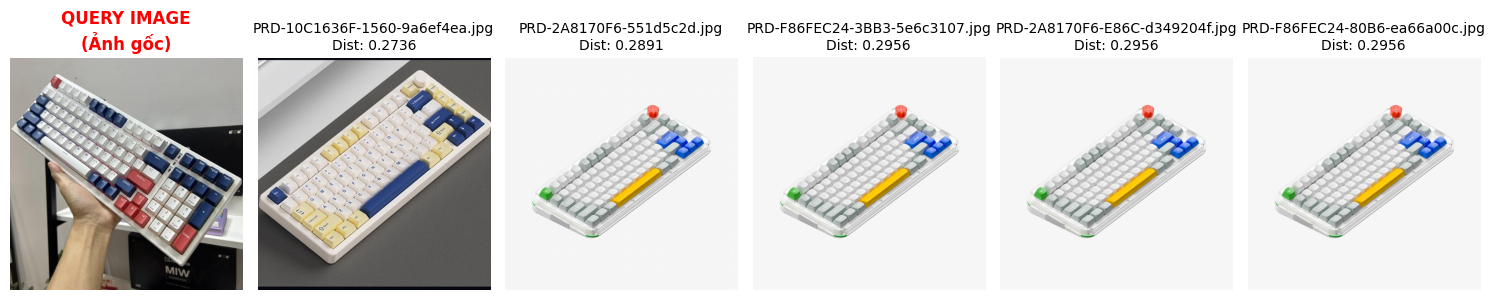

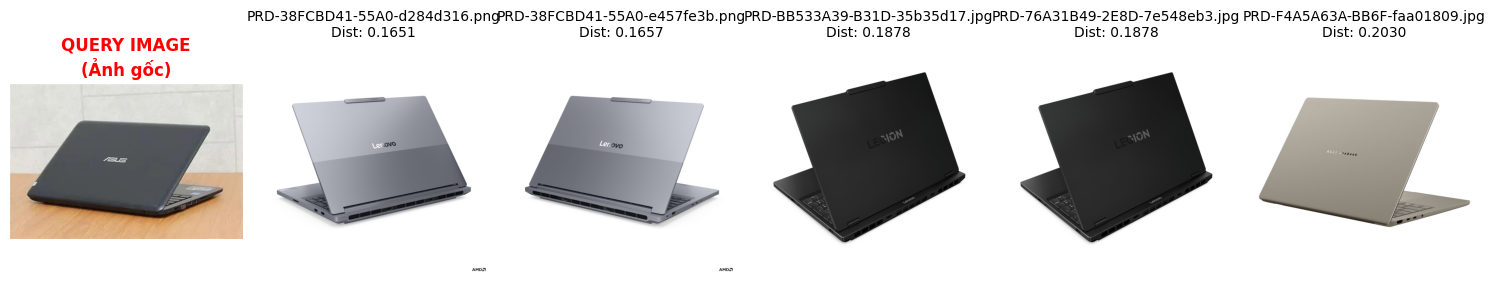

In [12]:
import requests
from PIL import Image
from io import BytesIO

def search_from_url(url):
    
    try:
        # 1. Tải ảnh từ URL
        headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'}
        response = requests.get(url, headers=headers, timeout=10)
        
        if response.status_code != 200:
            print(f"❌ Lỗi: Không tải được ảnh (Status Code: {response.status_code})")
            return

        img = Image.open(BytesIO(response.content))
        
        # Chuyển đổi sang RGB nếu là ảnh PNG (trong suốt) để tránh lỗi ResNet
        if img.mode != 'RGB':
            img = img.convert('RGB')
            
        temp_filename = "temp_query_image.jpg"
        img.save(temp_filename)
        
        search_similar_images(temp_filename)
        
    except Exception as e:
        print(f"❌ Lỗi xảy ra: {e}")

# test
sample_url = "https://tse1.mm.bing.net/th/id/OIP.z7017oEmEauc7GF7gVAjDgHaHa?rs=1&pid=ImgDetMain&o=7&rm=3"

search_from_url(sample_url)

sample_url = "https://file.hstatic.net/1000356871/file/1_tay-arm-man-hinh-27-inch-nb-chinh-hang_26eb845b7033424fab1d598e1f7dc101.jpg"

search_from_url(sample_url)


sample_url = "https://bizweb.dktcdn.net/thumb/grande/100/436/596/products/z5017495491273-0ee114b83cbbe9c4f45f232ccf8f9141-1703746801779.jpg?v=1703746863067"

search_from_url(sample_url)


sample_url = "https://tse4.mm.bing.net/th/id/OIP.I3nif9Wi2EiS2QCFWXJLZAHaE8?rs=1&pid=ImgDetMain&o=7&rm=3"

search_from_url(sample_url)



In [13]:
"""
TODO:
Mapping id product thay vì slug từ link ảnh
Lưu lại feature_list, indextoId và triển khai trên python server: gọi KNN và fitlaij feature_list
"""

'\nTODO:\nMapping id product thay vì slug từ link ảnh\nLưu lại feature_list, indextoId và triển khai trên python server: gọi KNN và fitlaij feature_list\n'